In [1]:
import os
if os.getcwd().endswith('lab03_svm'):
    os.chdir('..')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
from lab03_svm.svm import solve_svm
import lab03_svm.methods.gradient as grad
import lab03_svm.methods.smo as smo

# Данные

In [5]:
data_sets = {}
for filename in ['chips', 'geyser']:
    next_data = pd.read_csv(f'lab03_svm/resources/{filename}.csv')
    next_data = next_data.replace({'P': 1, 'N': -1})
    data_sets[filename] = next_data.sample(frac=1).reset_index(drop=True)

In [6]:
data_sets['chips']

,x,y,class
0,-0.23675,-0.63816,-1
1,-0.43836,0.21711,1
2,0.51786,-0.59430,-1
3,-0.48445,0.99927,-1
4,0.59274,-0.74050,-1
...,...,...,...
113,-0.13306,-0.44810,-1
114,0.79435,-0.55775,-1
115,0.61578,0.72880,-1
116,0.22984,-0.41155,1


In [7]:
data_sets['geyser']

,x,y,class
0,18,4.8,-1
1,4,3.8,-1
2,6,3.5,-1
3,5,3.7,-1
4,8,2.0,1
...,...,...,...
217,4,3.8,-1
218,8,2.7,1
219,2,4.6,-1
220,5,3.7,-1


# Описание гиперпараметров

In [8]:
from lab03_svm.utils.kernels import Kernel as K

kernels = {
    'linear': K.linear(),
    'd2': K.polynomial(2),
    'd3': K.polynomial(3),
    'd4': K.polynomial(4),
    'd5': K.polynomial(5),
    'g1': K.gauss(1),
    'g2': K.gauss(2),
    'g3': K.gauss(3),
    'g4': K.gauss(4),
    'g5': K.gauss(5)
}
Cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

# Запуск

Для начала запустим с небольшим количеством итераций (пока что используем только градиентный спуск без smo), чтобы перебрать все параметры и найти оптимальный набор (для каждого датасета).
Затем, когда найдем оптимальные, запустим на большем числе итераций и построим в результате графики.

In [9]:
results = {}
for name, data in data_sets.items():
    print(f'Dataset {name}:')
    results[name] = solve_svm(
        data, 
        grad.solve, 
        Cs, 
        kernels, 
        iterations=1000,
        lmbd=lambda _: 1e-5
    )

Dataset chips:
-- finished 5 of 80
-- finished 10 of 80
-- finished 15 of 80
-- finished 20 of 80
-- finished 25 of 80
-- finished 30 of 80
-- finished 35 of 80
-- finished 40 of 80
-- finished 45 of 80
-- finished 50 of 80
-- finished 55 of 80
-- finished 60 of 80
-- finished 65 of 80
-- finished 70 of 80
-- finished 75 of 80
-- finished 80 of 80
Dataset geyser:


C:\Users\jetbrains\PycharmProjects\itmo-ml\lab03_svm\methods\gradient.py:27: RuntimeWarning: invalid value encountered in subtract
  alpha -= reg * y_m


-- finished 5 of 80


KeyboardInterrupt: 

In [10]:
for name, result in results.items():
    print(f'Dataset {name}:')
    for row in result[:10]:
        print('-', row)

Dataset chips:
- (0.05, 'g2', (0.3333333333333333, 0.5666666666666667))
- (0.05, 'g4', (0.3333333333333333, 0.5666666666666667))
- (0.1, 'g2', (0.3333333333333333, 0.5666666666666667))
- (0.1, 'g4', (0.3333333333333333, 0.5666666666666667))
- (0.5, 'g2', (0.3333333333333333, 0.5666666666666667))
- (0.5, 'g4', (0.3333333333333333, 0.5666666666666667))
- (1.0, 'g2', (0.3333333333333333, 0.5666666666666667))
- (1.0, 'g4', (0.3333333333333333, 0.5666666666666667))
- (5.0, 'g2', (0.3333333333333333, 0.5666666666666667))
- (5.0, 'g4', (0.3333333333333333, 0.5666666666666667))


# Построение графиков

In [11]:
from utils.metrics import accuracy
from lab03_svm.svm import score, predict

def solve_local(x, y, C, kernel):
    return grad.solve(
        x, y, C, kernel,
        100000, lambda _: 3e-5
    )    


colors = ['#aa4040', '', '#4040aa', '#cc5555', '', '#5555cc']
def pick_color(t):
    return colors[int(t) + 1]
pc = np.vectorize(pick_color)
def pick_color2(t):
    return colors[int(t) - 2] if not np.isnan(t) else '#aaaaaa'
pc2 = np.vectorize(pick_color2)


def plot(data, C, kernel, plot=None, xlim=None, ylim=None):
    x = data.drop(['class'], axis=1).to_numpy()
    y = data['class'].to_numpy()
    alpha, w0 = solve_local(x, y, C, kernel)
    
    if plot is None:
        y_pred = np.array(predict(x, y, alpha, w0, kernel, x))[0]
        data_pred = pd.DataFrame(x, columns=['x', 'y'])
    else:
        xspace = np.linspace(xlim[0], xlim[1], 200)
        yspace = np.linspace(ylim[0], ylim[1], 200)
        xx, yy = np.meshgrid(xspace, yspace)
        X = np.array([xx.flatten(), yy.flatten()]).T
        data_pred = pd.DataFrame(X, columns=['x', 'y'])
        y_pred = np.array(predict(x, y, alpha, w0, kernel, X))[0]
        
    if plot is None:
        data.plot.scatter(x='x', y='y', c=pc(data['class']))
        acc = accuracy(y, y_pred)
        print(f'Predicted (with accuracy {acc}):')
        data_pred.plot.scatter(x='x', y='y', c=pc(y_pred))
    else:
        plot.scatter(x=data_pred['x'], y=data_pred['y'], c=pc2(y_pred))
        plot.scatter(x=data['x'], y=data['y'], c=pc(data['class']))
    
    return score(x, y, alpha, w0, kernel, x, y)

Predicted (with accuracy 0.7627118644067796):


0.7627118644067796

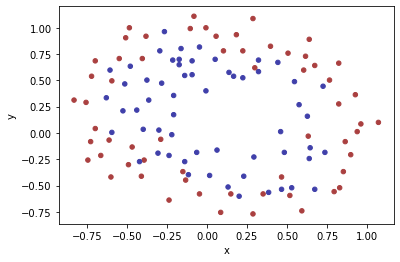

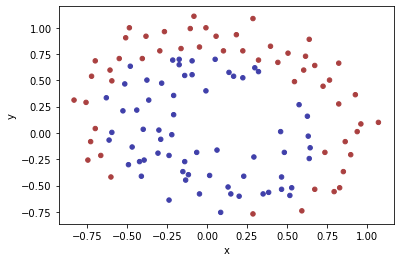

In [12]:
plot(data_sets['chips'], 0.05, K.gauss(3))

Predicted (with accuracy 0.9099099099099099):


0.9099099099099099

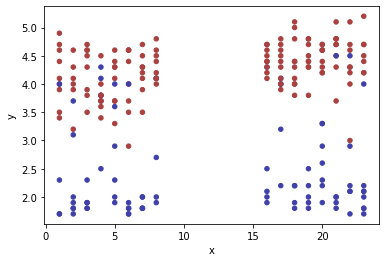

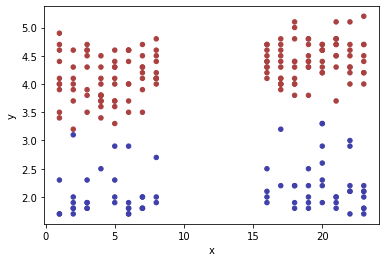

In [13]:
plot(data_sets['geyser'], 0.05, K.linear())

In [14]:
def solve_local(x, y, C, kernel):
    return grad.solve(
        x, y, C, kernel,
        10000, lambda _: 3e-5
    )   

plt.ion()

def plot_meshgrid(data, Cs1, kernels1, xlim, ylim):
    fig, axs = plt.subplots(len(Cs1), len(kernels1), figsize=(20, 5 * len(Cs1)))
    for i, C in enumerate(Cs1):
        for j, (name, kernel) in enumerate(kernels1.items()):
            ax = axs[i][j] if len(Cs1) > 1 else axs[j]
            acc = plot(data, C, kernel, ax, xlim, ylim)
            ax.title.set_text(f'{C}, {name}, acc={"%.3f" % acc}')

In [15]:
kernels1 = {
    'linear': K.linear(),
    'deg2': K.polynomial(2),
    'gauss1': K.gauss(1),
    'gauss4': K.gauss(3)
}

Predicted (with accuracy 0.5508474576271186):
Predicted (with accuracy 0.7372881355932204):
Predicted (with accuracy 0.8135593220338984):
Predicted (with accuracy 0.8305084745762712):


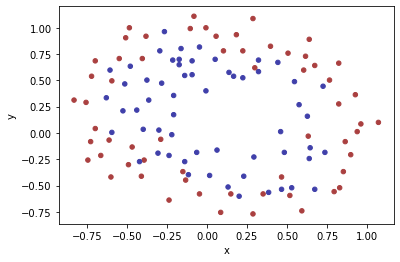

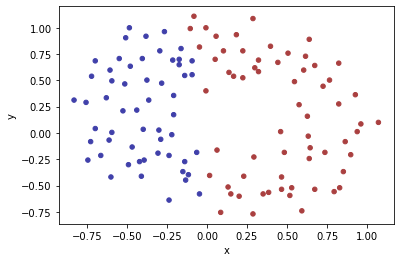

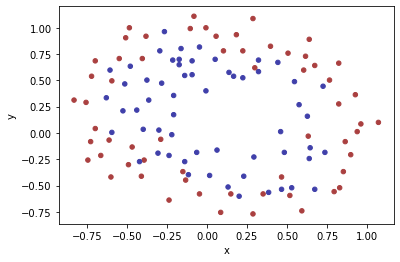

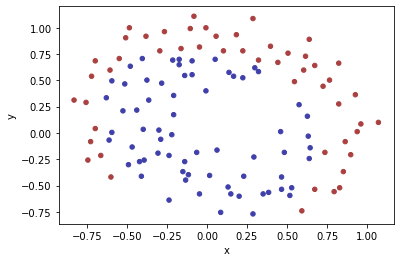

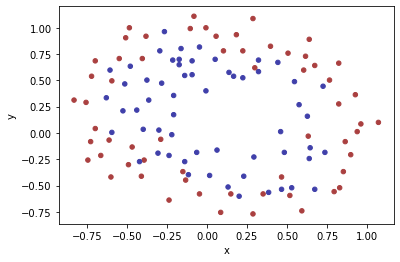

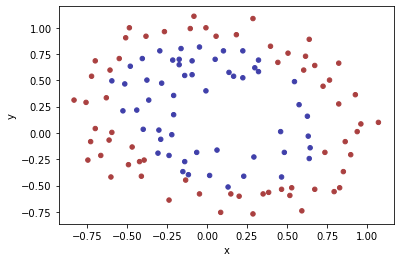

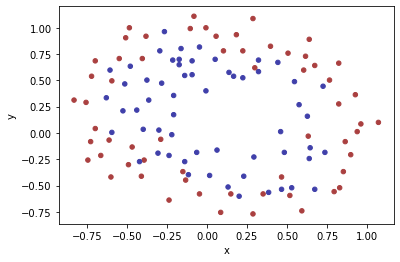

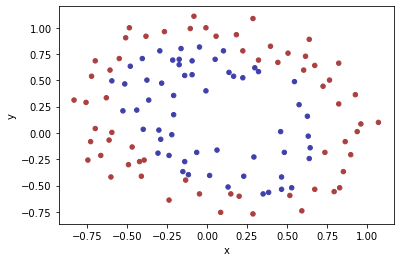

In [16]:
for name, kernel in kernels1.items():
    plot(data_sets['chips'], 0.05, kernel)

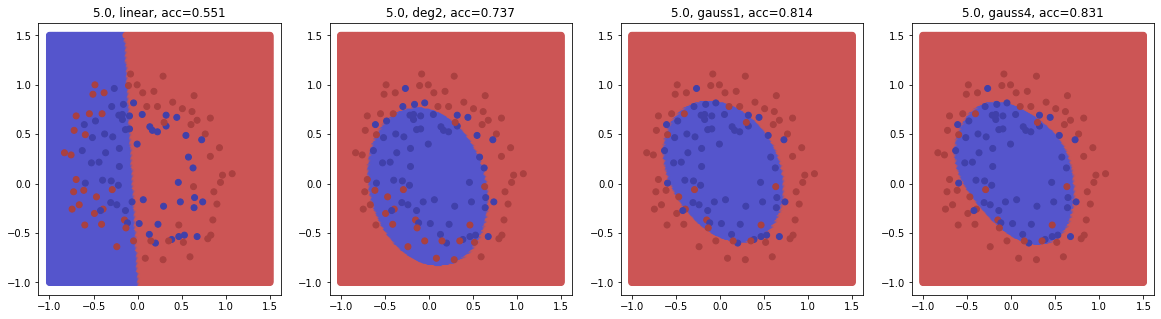

In [17]:
plot_meshgrid(data_sets['chips'], [5.0], kernels1, (-1, 1.5), (-1, 1.5))

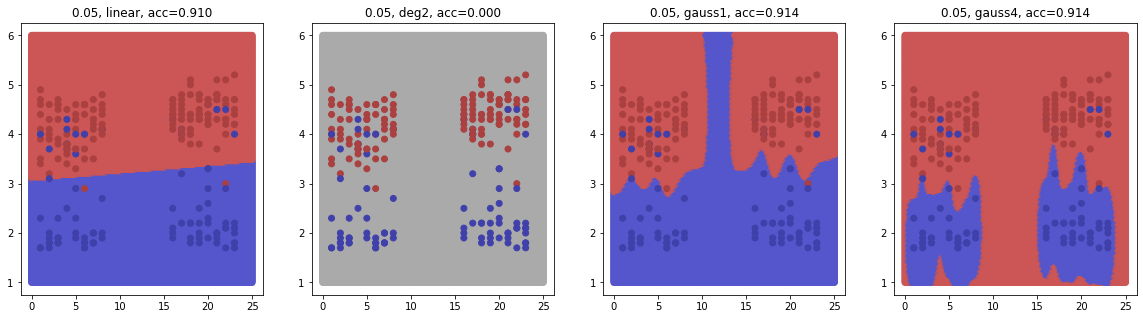

In [18]:
plot_meshgrid(data_sets['geyser'], [0.05], kernels1, (0, 25), (1, 6))

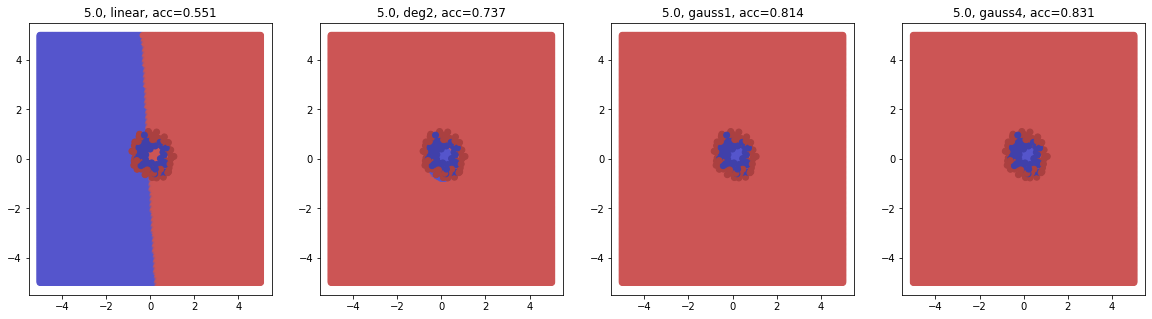

In [19]:
plot_meshgrid(data_sets['chips'], [5.0], kernels1, (-5, 5), (-5, 5))